In [ ]:
!pip install '/content/pyGPB-0.0.1.tar.gz'

Processing ./pyGPB-0.0.1.tar.gz
  Created wheel for pyGPB: filename=pyGPB-0.0.1-py3-none-any.whl size=8673 sha256=23c9f9f4de2007a7020d709cf14dbf7de2b6844c987e3125bab291e7ccedc7b7
  Stored in directory: /root/.cache/pip/wheels/18/9e/73/f0be66f2d221d99a8ecad80a5f64821626f2a6c13e8f039eab
Successfully built pyGPB


In [ ]:
import numpy as np
import pickle
import timeit
import numba
import math
from pyGPB._cpu_methods import _GPB_Naive, _GPB_CF, _GPB_DP,  _GPB_DC_FFT, _GPB_DP_DC_FFT_Combo
from pyGPB._gpu_methods import _GPB_DP_CUDA, _GPB_DP_DC_FFT_Combo_CUDA
from matplotlib import pyplot as plt

In [ ]:
# Test space definition
NUMBER_OF_TEST_CASES_PER_SCENARIO = 16
M_space = np.logspace(1,4,num=25, dtype=np.int32)
N_space = np.logspace(3,7,num=25, dtype=np.int32)
N_space_small = np.array([100,200,500,1000,2000,5000,10000])
M_space_small = np.array([5,10,15,20,25])
weight_distribution_space = ['uniform', 'poisson', 'geometric']
prob_distribution_space = ['uniform', 'near_0', 'near_1']
N_space, M_space, N_space_small, M_space_small, weight_distribution_space, prob_distribution_space

(array([    1000,     1467,     2154,     3162,     4641,     6812,
           10000,    14677,    21544,    31622,    46415,    68129,
          100000,   146779,   215443,   316227,   464158,   681292,
         1000000,  1467799,  2154434,  3162277,  4641588,  6812920,
        10000000], dtype=int32),
 array([   10,    13,    17,    23,    31,    42,    56,    74,   100,
          133,   177,   237,   316,   421,   562,   749,  1000,  1333,
         1778,  2371,  3162,  4216,  5623,  7498, 10000], dtype=int32),
 array([  100,   200,   500,  1000,  2000,  5000, 10000]),
 array([ 5, 10, 15, 20, 25]),
 ['uniform', 'poisson', 'geometric'],
 ['uniform', 'near_0', 'near_1'])

In [ ]:
# Load test data
test_case_weights = pickle.load( open( '/content/drive/MyDrive/MSc Project/test_cases_weights.p', "rb" ) )
test_case_probs = pickle.load( open( '/content/drive/MyDrive/MSc Project/test_cases_probabilities.p', "rb" ) )

In [ ]:
test_case_weights_small = pickle.load( open( '/content/drive/MyDrive/MSc Project/test_cases_weights_small.p', "rb" ) )
test_case_probs_small = pickle.load( open( '/content/drive/MyDrive/MSc Project/test_cases_probabilities_small.p', "rb" ) )

### Potential Accuracy Benchmark by comparing two implementations of the Naive Approach

In [ ]:
@numba.jit
def _GPB_Naive_Stack(probs, weights):
    a = np.zeros(weights.sum()+1, dtype=np.float64)
    M = probs.shape[0]
    stack = []
    stack.append((0, 1.0, 0))
    while stack:
        t, p, w = stack.pop()
        if t == M-1:
            a[w+weights[t]] += p * probs[t]
            a[w] += p * (1 - probs[t])
        else:
            stack.append((t+1, p * probs[t], w+weights[t]))
            stack.append((t+1, p * (1 - probs[t]), w))
    return a       

In [ ]:
_GPB_Naive_Stack(np.array([0.1,0.2,0.3]),np.array([1,2,3]))

array([0.504, 0.056, 0.126, 0.23 , 0.024, 0.054, 0.006])

In [ ]:
for M in M_space_small:
    for N in N_space_small:
        for weight_distribution in weight_distribution_space:
            for prob_distribution in prob_distribution_space:
                weight_cases = test_case_weights_small[(weight_distribution, N, M)]
                prob_cases = test_case_probs_small[(prob_distribution, M)]
                TAEs = np.zeros(NUMBER_OF_TEST_CASES_PER_SCENARIO, dtype=np.float64)
                MAEs = np.zeros(NUMBER_OF_TEST_CASES_PER_SCENARIO, dtype=np.float64)
                for i, (probs, weights) in enumerate(zip(prob_cases, weight_cases)):
                    bitflag_cdf = _GPB_Naive(probs,weights).cumsum()
                    stack_cdf = _GPB_Naive_Stack(probs,weights).cumsum()
                    abs_errors = np.abs(bitflag_cdf-stack_cdf)
                    TAE = abs_errors.sum()
                    MAE = abs_errors.max()
                    TAEs[i] = TAE
                    MAEs[i] = MAE
                print(M, N, weight_distribution, prob_distribution, TAEs.mean(), TAEs.std(), MAEs.mean(), MAEs.std())

5 100 uniform uniform 0.0 0.0 0.0 0.0
5 100 uniform near_0 5.405398351143731e-15 5.472385853446947e-15 9.020562075079397e-17 8.062266159279859e-17
5 100 uniform near_1 0.0 0.0 0.0 0.0
5 100 poisson uniform 0.0 0.0 0.0 0.0
5 100 poisson near_0 7.147060721024445e-15 5.2906415520937315e-15 1.3183898417423734e-16 8.967027109257956e-17
5 100 poisson near_1 0.0 0.0 0.0 0.0
5 100 geometric uniform 0.0 0.0 0.0 0.0
5 100 geometric near_0 7.667477763817487e-15 5.740839261996762e-15 1.1102230246251565e-16 7.850462293418876e-17
5 100 geometric near_1 0.0 0.0 0.0 0.0
5 200 uniform uniform 0.0 0.0 0.0 0.0
5 200 uniform near_0 1.173020014455517e-14 1.1478243021475425e-14 1.0408340855860843e-16 8.297710257163942e-17
5 200 uniform near_1 0.0 0.0 0.0 0.0
5 200 poisson uniform 0.0 0.0 0.0 0.0
5 200 poisson near_0 1.8030715809302933e-14 1.468153491067376e-14 1.457167719820518e-16 1.0174415683999446e-16
5 200 poisson near_1 0.0 0.0 0.0 0.0
5 200 geometric uniform 0.0 0.0 0.0 0.0
5 200 geometric near_0 1.30

#### Show that DP approach is as accurate as Naive approach with extra precision implementations

In [ ]:
def _GPB_Naive_Stack_Precise(probs, weights):
    a = np.zeros(weights.sum()+1, dtype=np.float128)
    M = probs.shape[0]
    stack = []
    stack.append((0, np.float128(1.0), 0))
    while stack:
        t, p, w = stack.pop()
        if t == M-1:
            a[w+weights[t]] += p * probs[t]
            a[w] += p * (1 - probs[t])
        else:
            stack.append((t+1, p * probs[t], w+weights[t]))
            stack.append((t+1, p * (1 - probs[t]), w))
    return a       

In [ ]:
_GPB_Naive_Stack_Precise(np.array([0.1,0.2,0.3]),np.array([1,2,3]))

array([0.504, 0.056, 0.126, 0.23 , 0.024, 0.054, 0.006], dtype=float128)

In [ ]:
def _GPB_DP_Precise(probs, weights):
  probs = probs[np.argsort(weights)].astype(np.float128)
  weights = np.sort(weights)
  a = np.zeros(weights.sum() + 1, dtype=np.float128)
  a[0] = np.float128(1.0)
  n = 1
  for p, w in zip(probs, weights):
      a[w:n+w] = a[w:n+w] * (1-p) + a[:n] * p
      a[:w] = a[:w] * (1-p)
      n += w
  return a

In [ ]:
for M in [ 5, 10, 15, 20]:
    for N in N_space_small:
        for weight_distribution in weight_distribution_space:
            for prob_distribution in prob_distribution_space:
                weight_cases = test_case_weights_small[(weight_distribution, N, M)]
                prob_cases = test_case_probs_small[(prob_distribution, M)]
                TAEs = np.zeros(NUMBER_OF_TEST_CASES_PER_SCENARIO, dtype=np.float64)
                MAEs = np.zeros(NUMBER_OF_TEST_CASES_PER_SCENARIO, dtype=np.float64)
                for i, (probs, weights) in enumerate(zip(prob_cases, weight_cases)):
                    naive_cdf = _GPB_Naive_Stack_Precise(probs,weights).cumsum()
                    dp_cdf = _GPB_DP_Precise(probs,weights).cumsum()
                    abs_errors = np.abs(naive_cdf-dp_cdf)
                    TAE = abs_errors.sum()
                    MAE = abs_errors.max()
                    TAEs[i] = TAE
                    MAEs[i] = MAE
                print(M, N, weight_distribution, prob_distribution, TAEs.mean(), TAEs.std(), MAEs.mean(), MAEs.std())

5 100 uniform uniform 2.0184646240559718e-18 2.016052747540288e-18 6.649208635946258e-20 3.603376120606425e-20
5 100 uniform near_0 7.124985348353104e-15 3.700028068820272e-15 7.54774118639362e-17 3.948239721076933e-17
5 100 uniform near_1 2.588476525798628e-19 4.306836436560901e-19 2.883220743116066e-20 3.60297694463144e-20
5 100 poisson uniform 1.0248858779399394e-18 1.184841758512229e-18 4.8069119756681544e-20 3.537757094556718e-20
5 100 poisson near_0 7.088744196671881e-15 3.7275632549105286e-15 7.534188659237551e-17 3.9586814525603864e-17
5 100 poisson near_1 1.9771787379325973e-19 3.1325720003978447e-19 2.2053048720969994e-20 3.002073239724981e-20
5 100 geometric uniform 2.5344851191752333e-18 2.1698636620148514e-18 6.183340514956392e-20 4.436221347130013e-20
5 100 geometric near_0 7.059611345484017e-15 3.644551296241772e-15 7.549435252288128e-17 3.94473157898734e-17
5 100 geometric near_1 1.779748745288396e-19 1.845014050799107e-19 2.040323698923298e-20 2.1725016618023524e-20
5 

### Testing Larger Test Scenarios

In [ ]:
approaches = {'FFT':_GPB_DC_FFT, 'DP_CUDA':_GPB_DP_CUDA, 'FFT_CUDA':_GPB_DP_DC_FFT_Combo_CUDA}

In [ ]:
for M in M_space[:17]:
    for N in N_space[:13]:
        if N > M:
            for weight_distribution in weight_distribution_space:
                for prob_distribution in prob_distribution_space:
                    weight_cases = test_case_weights[(weight_distribution, N, M)]
                    prob_cases = test_case_probs[(prob_distribution, M)]
                    df_cdfs = []
                    for i, (probs, weights) in enumerate(zip(prob_cases, weight_cases)):
                        df_cdfs.append(_GPB_DP(probs,weights).cumsum())
                    for approach_name, approach_function in approaches.items():   
                        TAEs = np.zeros(NUMBER_OF_TEST_CASES_PER_SCENARIO, dtype=np.float64)
                        MAEs = np.zeros(NUMBER_OF_TEST_CASES_PER_SCENARIO, dtype=np.float64)
                        for i, (probs, weights) in enumerate(zip(prob_cases, weight_cases)):
                            cdf = approach_function(probs,weights).cumsum()
                            if approach_name in ('DP_CUDA','FFT_CUDA'):
                                cdf = cdf.get()
                            abs_errors = np.abs(cdf-df_cdfs[i])
                            TAE = abs_errors.sum()
                            MAE = abs_errors.max()
                            TAEs[i] = TAE
                            MAEs[i] = MAE
                        print(M, N, weight_distribution, prob_distribution, approach_name, TAEs.mean(), TAEs.std(), MAEs.mean(), MAEs.std())

Streaming output truncated to the last 5000 lines.
17 21544 geometric near_0 DP_CUDA 5.974603450864535e-11 2.10541887008473e-11 7.958911307781591e-15 2.9719777527263106e-15
17 21544 geometric near_0 FFT_CUDA 5.873189651631194e-11 2.023557887449501e-11 7.86176679312689e-15 2.9798732277301966e-15
17 21544 geometric near_1 FFT 5.157642251223726e-12 2.6298554862545646e-12 1.3279308208602458e-15 4.649503902676139e-16
17 21544 geometric near_1 DP_CUDA 2.2153190348389238e-12 1.5754804830755506e-12 1.0408340855860843e-15 4.793364605007606e-16
17 21544 geometric near_1 FFT_CUDA 4.065089076225238e-12 2.384658802708063e-12 1.0865946170450242e-15 5.381282940247936e-16
17 31622 uniform uniform FFT 1.2233768610846626e-11 6.388078743119436e-12 9.159339953157541e-16 3.835896867111847e-16
17 31622 uniform uniform DP_CUDA 2.6022904290434998e-11 1.6213435680865924e-11 3.4486302702418925e-15 1.384148460400044e-15
17 31622 uniform uniform FFT_CUDA 2.682178959473794e-11 1.706134232236286e-11 3.4763858458575

In [ ]:
_GPB_DP_Precise(np.array([0.1,0.2,0.3]),np.array([1,2,3]))

array([0.504, 0.056, 0.126, 0.23 , 0.024, 0.054, 0.006], dtype=float128)

In [ ]:
weight_cases = test_case_weights[('uniform', 10000, 100)]
prob_cases = test_case_probs[('uniform', 100)]

In [ ]:

DP = _GPB_DP(prob_cases[0],weight_cases[0])
FFT = _GPB_DC_FFT(prob_cases[0],weight_cases[0])

In [ ]:
rel_error = 2*np.abs(FFT-DP)/(FFT+DP)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


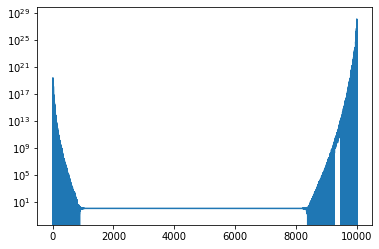

In [ ]:
#plt.plot(FFT)
plt.plot(abs(FFT/DP))
plt.yscale('log')

In [ ]:
np.savetxt("DP_pmf.csv", DP, delimiter=",")

In [ ]:
np.savetxt("FFT_pmf.csv", FFT, delimiter=",")